In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import ants
import matplotlib.pyplot as plt

from dp_model import dp_utils as dpu, dp_loss as dpl
from dp_model.model_files.sfcn import SFCN
from dp_model.evaluation import predict_and_eval

from utils import explore_3D_array

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'CUDA using the device: {device}')

CUDA using the device: cuda


In [32]:
csv_file = Path('data/ABIDE_1/sampled_age_44_80.csv')
df = pd.read_csv(csv_file)

# rename columns to match dp_model.evaluation.BrainAgeDataset
df.rename(columns={'Subject': 'scan_id', 'Age': 'age'}, inplace=True)

# adding preprocessed image path to use dp_model.evaluation.BrainAgeDataset
mni_reg_dir = Path('data/ABIDE_1/mni_reg')
# column 'preproc_image' should exactly match since this string is used in dp_model.evaluation.BrainAgeDataset
df['preproc_image'] = df['scan_id'].apply(
    lambda subject_id: str(mni_reg_dir / f'{subject_id}_mprage.nii.gz')
)

# example row
example_row = df.iloc[5]
processed_image_file, true_age = Path(example_row['preproc_image']), example_row['age']
print(f"Processed image file: {processed_image_file}")
print(f"True age: {true_age}")
print(df.head())

# visualize the processed image
image = ants.image_read(str(processed_image_file))
print("processed image orientation: ", image.get_orientation())
explore_3D_array(image.reorient_image2('IAR').numpy())

Processed image file: data/ABIDE_1/mni_reg/MaxMun_51371_mprage.nii.gz
True age: 48
         scan_id  age                                         Image Path  \
0  Caltech_51469   45  data/ABIDE_1/raw/Caltech_51469/anat/NIfTI/mpra...   
1  Caltech_51475   44  data/ABIDE_1/raw/Caltech_51475/anat/NIfTI/mpra...   
2  Caltech_51490   44  data/ABIDE_1/raw/Caltech_51490/anat/NIfTI/mpra...   
3   MaxMun_51321   45  data/ABIDE_1/raw/MaxMun_51321/anat/NIfTI/mprag...   
4   MaxMun_51330   45  data/ABIDE_1/raw/MaxMun_51330/anat/NIfTI/mprag...   

                                      preproc_image  
0  data/ABIDE_1/mni_reg/Caltech_51469_mprage.nii.gz  
1  data/ABIDE_1/mni_reg/Caltech_51475_mprage.nii.gz  
2  data/ABIDE_1/mni_reg/Caltech_51490_mprage.nii.gz  
3   data/ABIDE_1/mni_reg/MaxMun_51321_mprage.nii.gz  
4   data/ABIDE_1/mni_reg/MaxMun_51330_mprage.nii.gz  
processed image orientation:  RPI


interactive(children=(IntSlider(value=90, description='SLICE', max=181), Output()), _dom_classes=('widget-inte…

Input data shape: torch.Size([1, 1, 160, 192, 160])
dtype: torch.float32
Label shape: torch.Size([1, 40])
Output shape: torch.Size([1, 40])


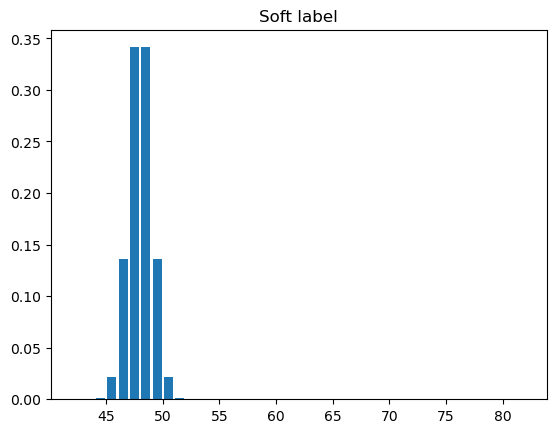

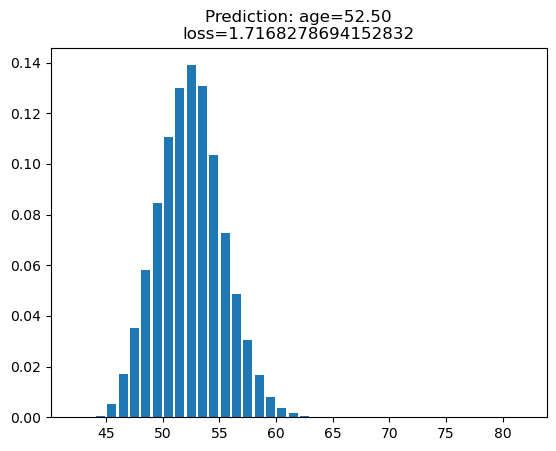

In [33]:
data_np: np.ndarray = image.numpy()
data_np = data_np / data_np.mean()
data_np = dpu.crop_center(data_np, (160, 192, 160))

# convert to torch tensor
sp = (1,1) + data_np.shape
data = data_np.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32).to(device)

print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Transforming the true label (age) to soft label (probability distribution)
label = np.array([true_age,])
bin_range = [42,82]
bin_step = 1
sigma = 1
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)
print(f'Label shape: {y.shape}')

# load model
model = SFCN()
model = torch.nn.DataParallel(model)
fp_ = './brain_age/run_20190719_00_epoch_best_mae.p'
model.load_state_dict(torch.load(fp_, map_location='cpu', weights_only=True))
model.to(device)

# evaluation
model.eval()
with torch.no_grad():
    output = model(input_data)

y_hat = output[0].cpu().reshape([1, -1])
print(f'Output shape: {y_hat.shape}')
loss = dpl.my_KLDivLoss(y_hat, y).numpy()


# Prediction, Visualisation and Summary
y_hat = y_hat.numpy().reshape(-1)
y = y.numpy().reshape(-1)

plt.bar(bc, y)
plt.title('Soft label')
plt.show()

prob = np.exp(y_hat)
pred = prob@bc
plt.bar(bc, prob)
plt.title(f'Prediction: age={pred:.2f}\nloss={loss}')
plt.show()


In [38]:
results_df, mae = predict_and_eval(model, df, device=device, batch_size=5)

print(f"MAE: {mae:.2f}")
print(f'number of test examples: {results_df.shape[0]}')
results_df.head(20)

MAE: 9.75
number of test examples: 10


,IXI_ID,true_age,pred_age
0,Caltech_51469,45.0,62.570869
1,Caltech_51475,44.0,58.987244
2,Caltech_51490,44.0,58.622288
3,MaxMun_51321,45.0,53.891575
4,MaxMun_51330,45.0,56.772552
5,MaxMun_51371,48.0,52.499184
6,MaxMun_51372,46.0,49.270435
7,MaxMun_51373,46.0,50.723415
8,SBL_51584,49.0,60.542221
9,USM_50526,50.0,55.649799
